In [1]:
import random_VQE_data_prep as ran_VQE
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold 
import os
import pickle
import re

import FeatureExtract as FE

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import LabelEncoder
from qiskit_aer import Aer
from qiskit_ibm_runtime.fake_provider import FakeQuitoV2

In [4]:
def count_gate_paris(df, gates:str):
    l = df[gates]
    res = dict()
    for i in range(len(l)):
        tmp = str(l[i])
        if tmp in res.keys():
            res[tmp] += 1
        else:
            res[tmp] = 1
    return res

`extract_features(path)` as function to store all relevant features from the circuit at the given path into a df to perform linear regression

In [2]:
ran_VQE.main()

In [6]:
def extract_features(path):
    with open(path, "rb") as file:
        dict_ = pickle.load(file)
    #print(dict)
    #print(len(dict["Quantum_circuit"]))
    data = dict_["Quantum_circuit"][0].__dict__["_data"]
    #print(dict["Quantum_circuit"][0].draw())
    circuit = dict_["Quantum_circuit"][0]

    qubits = str(data)
    #print(qubits)

    # Split input_string before each "CircuitInstruction"
    instructions = qubits.split("CircuitInstruction")

    # Remove the empty string at the beginning (resulting from the initial split)
    instructions = instructions[1:]

    #patterns to get different values from datastring
    pattern_nq = r"num_qubits=(\d+)"
    pattern_nc = r"num_clbits=(\d+)"
    pattern_n = r"name='(\w+)'"
    pattern_p = r"params=\[(.*?)\]"
    pattern_gates = r"Qubit\(QuantumRegister\(5, 'q'\), (\d+)\)"
    #pattern_clb = r'clbits=\(\)\)' -> possibly clbits relevant?

    # Extracted numbers
    # find all values and store them in array to build df
    numbers = [int(match) for match in re.findall(pattern_nq, qubits)]
    clbits = [int(match_cl) for match_cl in re.findall(pattern_nq, qubits)]
    name = [match_name for match_name in re.findall(pattern_n, qubits)]
    params = [match_p for match_p in re.findall(pattern_p, qubits)]

    # loop over all Instructions to get per instruction a list of used qubits
    gates_all = []
    for instr in enumerate(instructions):
        gates = [match_gates for match_gates in re.findall(pattern_gates, str(instr))]
        gates_all.append(gates)


    #create new df to show parameters
    df_new =pd.DataFrame({'name': name, 'num_qubits': numbers, 'num_clbits': clbits, 'params': params, 'gates': gates_all})
    df_new = df_new.sort_values(by='num_qubits', ascending=False)
    df_new = df_new[df_new['num_qubits'] == 2].reset_index()

    res = dict()
    res['noisy_expectation'] = dict_['noisy_expectation']
    res['num_layers'] = dict_['num_layers']

    res['tot_num_gates'] = circuit.size()
    gates = circuit.count_ops()
    res['num_cx_gates'] = gates['cx']
    res['num_sx_gates'] = gates['sx']
    res['num_2_qubit_gates'] = len(df_new)

    

    # encoded obervable as binary number for locations where measured
    input_string = dict_['obervable']
    encoded_string = ''.join(['0' if char == 'I' else '1' for char in input_string])

    # le = LabelEncoder()
    # obs = ran_VQE.create_all_single_q_observables()
    # encoded = le.fit_transform(obs)
    # for index, item in enumerate(obs):
    #     if item == input_string:
    #         res['observable'] = encoded[index]

    res['obs_dummy_1'] = int(not dict_['obervable'][0]=="I")
    res['obs_dummy_2'] = int(not dict_['obervable'][1]=="I")
    res['obs_dummy_3'] = int(not dict_['obervable'][2]=="I")
    res['obs_dummy_4'] = int(not dict_['obervable'][3]=="I")
    res['obs_dummy_5'] = int(not dict_['obervable'][4]=="I")
    
    tmp = count_gate_paris(df_new, 'gates')
    for i in tmp.keys():
        res['count_' + i] = tmp[i]
    res['target'] = dict_['ideal_expectation']

    return res 
extract_features("./pickles/circ_5.pickle")

TypeError: CircuitInstruction.__new__() missing 1 required positional argument: 'operation'

In [13]:
# def label_encode(categories):
#     le = LabelEncoder()
#     encoded = le.fit_transform(categories)
#     return encoded

# # Example usage
# obs = ran_VQE.create_all_single_q_observables()
# #categories = ['XIIII', 'IXIII', 'IIXII', 'IIIXI', 'IIIIX']
# encoded = label_encode(obs)
# print(f"Encoded: {encoded}")
# obs

Split the generated data into an validation and train/test set. `train_frac` can be chosen and decides how many percent of the data are used to train and test the model.

In [14]:
def split_data(path="./pickles", train_frac = 0.8):
    ### split data into evaluation and training set
    assert train_frac < 1
    assert train_frac >= 0

    # shuffle data randomly to make different datasets
    all_files = os.listdir(path)
    # data_size = data.shape[0] # data.shape[0] changed to fit dictionary
    # indices = np.arange(data_size)  
    np.random.shuffle(all_files)
    #data_shuffled = data[indices]

    # split shuffeled data into test, train and eval according to fractions
    idx_eval = int(train_frac * len(all_files))

    files_train = all_files[:idx_eval]
    files_eval = all_files[idx_eval:]

    return files_train, files_eval

files_train, files_eval = split_data()

`file_to_data(files)` takes a list of circuits and generates the data using `extract_features(path)`

In [15]:
def file_to_data(files):
    a = list()
    for i, idx in enumerate(files):
        a.append(extract_features(f"./pickles/{idx}"))
    df = pd.DataFrame(a)
    return df

df_eval = file_to_data(files_eval)
df_train = file_to_data(files_train)

TypeError: CircuitInstruction.__new__() missing 1 required positional argument: 'operation'

In [ ]:
#df_train

`split_data_kfold(df_train)` returns all the training and test data, as features (X) and the value to predict (y)

In [ ]:
def split_data_kfold(df_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X_train = []
    X_test = []
    y_train = []
    y_test = []

    X = df_train.drop(columns=['target'])
    y = df_train['target']
    
    for train_index, test_index in kf.split(df_train):
        X_train.append(X.iloc[train_index])
        X_test.append(X.iloc[test_index])
        y_train.append(y.iloc[train_index])
        y_test.append(y.iloc[test_index])
        
    return X_train, X_test, y_train, y_test

# Ensure the data is correct and check the type of first element
X_train, X_test, y_train, y_test = split_data_kfold(df_train)
#print(X_train[0], y_train[0])

`Linear_Reg(data)` returns the best model of the k = 5 splits according to the R2

In [ ]:
def Linear_Reg():
    # returns best fitting linear model of all trained models based on MSE
    # X_train, y_train, X_test, y_test are numpy arrays
    # returns best model, MSE, R2
    #X_train, X_test, y_train, y_test = split_data_kfold(df_train)

    best_model = None
    best_model_MSE = float('inf')
    best_model_R2 = float('-inf')
    
    for i in range(len(X_train)):
        if X_train[i].empty or y_train[i].empty:
            print(f"Skipping fold {i} due to empty training data.")
            continue       
        
        model = LinearRegression()
        model.fit(X_train[i], y_train[i])
        y_pred = model.predict(X_test[i])

        MSE = mean_squared_error(y_test[i], y_pred)
        R2 = r2_score(y_test[i], y_pred)

        print(f'Fold {i} - MSE: {MSE:.4f}, R2: {R2:.4f}')
        
        if R2 > best_model_R2:
            best_model = model
            best_model_MSE = MSE
            best_model_R2 = R2
    return best_model, best_model_MSE, best_model_R2

best_model_lin, MSE, R2 = Linear_Reg()
print (f'MSE: {MSE}; R2: {R2}')

Fold 0 - MSE: 0.0792, R2: 0.4681
Fold 1 - MSE: 0.0751, R2: 0.5181
Fold 2 - MSE: 0.0620, R2: 0.6316
Fold 3 - MSE: 0.0857, R2: 0.4520
Fold 4 - MSE: 0.0919, R2: 0.5252
MSE: 0.06200867085719343; R2: 0.6316202913932121


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

def Lin_Reg_Interaction():
    # Linear Regression with Interaction Terms
    poly = PolynomialFeatures(interaction_only=True,include_bias = False)
    X_poly = poly.fit_transform(df_train.drop(columns=['target']))

    lri = LinearRegression()
    lri.fit(X_poly, df_train['target'])

    X_eval = df_eval.drop(columns=['target']).reindex(columns=X_train[0].columns)
    y_eval = df_eval['target']

    X_poly_eval = poly.fit_transform(df_eval.drop(columns=['target']))
    y_pred_lri = lri.predict(X_poly_eval)
    MSE_lri = mean_squared_error(y_eval, y_pred_lri)
    R2_lri = r2_score(y_eval, y_pred_lri)

    #print(lri.coef_)

    return MSE_lri, R2_lri

MSE_lri, R2_lri = Lin_Reg_Interaction()

In [ ]:
from sklearn.feature_selection import f_regression

poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(df_train.drop(columns=['target']))

f_stat, p_val = f_regression(X_poly, df_train['target'])

df = pd.DataFrame({'Feature': pd.DataFrame(X_poly).columns, 'F-statistic': f_stat, 'p-value': p_val})
df_large_p = df[df['p-value'] > 0.05]
#display(df_large_p)

features_to_remove = df_large_p['Feature'].tolist()

# Remove these features from df_train
df_train_reduced_no_out = pd.DataFrame(X_poly).drop(columns=features_to_remove)
#df_train_reduced_no_out

In [ ]:
# lri = LinearRegression()
# lri.fit(df_train_reduced_no_out, df_train['target'])

# X_poly_eval = poly.fit_transform(df_eval.drop(columns=['target']))
# X_poly_eval = pd.DataFrame(X_poly_eval).drop(columns=features_to_remove)
# y_pred_lri = lri.predict(X_poly_eval)
# MSE_lri = mean_squared_error(df_eval['target'], y_pred_lri)
# MSE_lri

In [ ]:
X_eval = df_eval.drop(columns=['target']).reindex(columns=X_train[0].columns)
y_eval = df_eval['target']

y_pred_eval_lin_reg = best_model_lin.predict(X_eval)

MSE_lin_reg = mean_squared_error(y_eval, y_pred_eval_lin_reg)
R2_lin_reg = r2_score(y_eval, y_pred_eval_lin_reg)

print(f'Evaluation of best model - MSE: {MSE_lin_reg:.4f}, R2: {R2_lin_reg:.4f}')
print(best_model_lin.coef_)
print(best_model_lin.intercept_)


Evaluation of best model - MSE: 0.0468, R2: 0.7181
[ 1.13470756e+00 -6.79517597e-05  3.89689297e-03 -5.43614077e-04
 -1.47144853e-02 -5.43614077e-04  1.90283659e-02  6.86337308e-02
 -1.19509531e-01  3.53842047e-03  2.83090136e-02 -1.35903519e-04
 -1.35903519e-04 -1.35903519e-04 -1.35903519e-04]
-0.03827443173009812


In [ ]:
#print(y_eval[:10], y_pred_eval[:10])

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

max_depth = [int(x) for x in np.linspace(1, 25, num = 5)]
max_depth.append(None)
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 110, num = 5)]

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': max_depth,
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [2, 4, 8],
    'n_estimators': n_estimators,
    'criterion': ['squared_error', 'absolute_error']
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                        cv = 3, n_jobs = -1, verbose = 2, n_iter=75, random_state=42)


In [ ]:
grid_search.fit(X_train[0], y_train[0])
y_pred = grid_search.predict(X_eval)

MSE_rf_hyperparam = mean_squared_error(y_eval, y_pred)
R2_rf_hyperparam = r2_score(y_eval, y_pred)

print(f'Evaluation of best model - MSE: {MSE_rf_hyperparam:.4f}, R2: {R2_rf_hyperparam:.4f}')

Fitting 3 folds for each of 75 candidates, totalling 225 fits
Evaluation of best model - MSE: 0.0492, R2: 0.7034


In [ ]:
#grid_search.best_params_

first test:
{'n_estimators': 200,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_depth': 10,
 'bootstrap': True}

second test: Evaluation of best model - MSE: 0.0831, R2: 0.5084

{'n_estimators': 35,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_depth': 7,
 'criterion': 'squared_error',
 'bootstrap': True}

In [ ]:
from sklearn.ensemble import RandomForestRegressor


def Random_Forest():
    # returns best fitting linear model of all trained models based on MSE
    # X_train, y_train, X_test, y_test are numpy arrays
    # returns best model, MSE, R2
    best_model = None
    best_model_MSE = float('inf')
    best_model_R2 = float('-inf')
    
    for i in range(len(X_train)): 

        rf = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=5)
        rf.fit(X_train[i], y_train[i])
        y_pred = rf.predict(X_test[i])

        MSE = mean_squared_error(y_test[i], y_pred)
        R2 = r2_score(y_test[i], y_pred)

        print(f'Fold {i} - MSE: {MSE:.4f}, R2: {R2:.4f}')
        
        if R2 > best_model_R2:
            best_model = rf
            best_model_MSE = MSE
            best_model_R2 = R2
    return best_model, best_model_MSE, best_model_R2

best_model_rf, MSE, R2 = Random_Forest()
print (f'MSE: {MSE}; R2: {R2}')

y_pred_eval_rf = best_model_rf.predict(X_eval)

MSE_rf = mean_squared_error(y_eval, y_pred_eval_rf)
R2_rf = r2_score(y_eval, y_pred_eval_rf)

print(f'Evaluation of best model - MSE: {MSE_rf:.4f}, R2: {R2_rf:.4f}')

Fold 0 - MSE: 0.0794, R2: 0.4665
Fold 1 - MSE: 0.0652, R2: 0.5814
Fold 2 - MSE: 0.0656, R2: 0.6105
Fold 3 - MSE: 0.0709, R2: 0.5469
Fold 4 - MSE: 0.0863, R2: 0.5544
MSE: 0.06556182310548393; R2: 0.610511804922421
Evaluation of best model - MSE: 0.0535, R2: 0.6776


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


def Random_Forest_hyp_tuning():
    # returns best fitting linear model of all trained models based on MSE
    # X_train, y_train, X_test, y_test are numpy arrays
    # returns best model, MSE, R2
    best_model = None
    best_model_MSE = float('inf')
    best_model_R2 = float('-inf')

    # max_depth = [int(x) for x in np.linspace(10, 60, num = 5)]
    # max_depth.append(None)
    # n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
    
    for i in range(len(X_train)): 

        # # Create the parameter grid based on the results of random search 
        # param_grid = {
        #     'bootstrap': [True, False],
        #     'max_depth': max_depth,
        #     'min_samples_leaf': [2, 3, 4],
        #     'min_samples_split': [2, 4, 8],
        #     'n_estimators': n_estimators
        # }
        # # Create a based model
        # rf = RandomForestRegressor()
        # # Instantiate the grid search model
        # grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
        #                         cv = 3, n_jobs = -1, verbose = 2)
        
        # grid_search.fit(X_train[i], y_train[i])
        # y_pred = grid_search.predict(X_test[i])
        
        grid_search.fit(X_train[i], y_train[i])
        y_pred_hyp_kfold = grid_search.predict(X_test[i])
        MSE_hyp_kfold = mean_squared_error(y_test[i], y_pred_hyp_kfold)
        R2_hyp_kfold = r2_score(y_test[i], y_pred_hyp_kfold)
        print(f'with hyperparameters and kfold: MSE: {MSE_hyp_kfold}, R2: {R2_hyp_kfold}')
        
        if R2_hyp_kfold > best_model_R2:
            best_model = grid_search
            best_model_MSE = MSE_hyp_kfold
            best_model_R2 = R2_hyp_kfold
    return best_model, best_model_MSE, best_model_R2

best_model_rf_hyp, MSE_hyp, R2_hyp = Random_Forest_hyp_tuning()
print (f'MSE: {MSE_hyp}; R2: {R2_hyp}')

y_pred_eval_rf_hyp = best_model_rf_hyp.predict(X_eval)

MSE_rf_hyp_kfold = mean_squared_error(y_eval, y_pred_eval_rf_hyp)
R2_rf_hyp_kfold = r2_score(y_eval, y_pred_eval_rf_hyp)

print(f'Evaluation of best model - MSE: {MSE_rf_hyp_kfold:.4f}, R2: {R2_rf_hyp_kfold:.4f}')

Fitting 3 folds for each of 75 candidates, totalling 225 fits
with hyperparameters and kfold: MSE: 0.0796127721243157, R2: 0.4652852767899266
Fitting 3 folds for each of 75 candidates, totalling 225 fits
with hyperparameters and kfold: MSE: 0.05891256887281572, R2: 0.6219841418066421
Fitting 3 folds for each of 75 candidates, totalling 225 fits
with hyperparameters and kfold: MSE: 0.05438549236444614, R2: 0.6769078976746488
Fitting 3 folds for each of 75 candidates, totalling 225 fits
with hyperparameters and kfold: MSE: 0.0685305827477064, R2: 0.5619112413479606
Fitting 3 folds for each of 75 candidates, totalling 225 fits
with hyperparameters and kfold: MSE: 0.0851384409155195, R2: 0.56024408240269
MSE: 0.05438549236444614; R2: 0.6769078976746488
Evaluation of best model - MSE: 0.0512, R2: 0.6915


XGboost

In [ ]:
# # KFold cross-validation
# def split_data_kfold_xg(df_train):
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     X_train_folds = []
#     X_test_folds = []
#     y_train_folds = []
#     y_test_folds = []

#     X = df_train.drop(columns=['target'])
#     y = df_train['target']

#     for train_index, test_index in kf.split(df_train):
#         X_train_folds.append(X.iloc[train_index])
#         X_test_folds.append(X.iloc[test_index])
#         y_train_folds.append(y.iloc[train_index])
#         y_test_folds.append(y.iloc[test_index])

#     return X_train_folds, X_test_folds, y_train_folds, y_test_folds

# X_train_folds, X_test_folds, y_train_folds, y_test_folds = split_data_kfold_xg(df_train)

In [ ]:
# from xgboost import XGBRegressor

# for X_train_xg, X_test_xg, y_train_xg, y_test_xg in zip(X_train_folds, X_test_folds, y_train_folds, y_test_folds):
#     model = XGBRegressor()
#     model.fit(X_train_xg, y_train_xg)

#     y_pred_train = model.predict(X_train_xg)
#     y_pred_test = model.predict(X_test_xg)

#     best_model_mse = float("inf")
#     best_model_r2 = float("-inf")
#     mse_test = mean_squared_error(y_test_xg, y_pred_test)
#     r2_test = r2_score(y_test_xg, y_pred_test)

#     if mse_test < best_model_mse:
#         best_model = model
#         best_model_mse = mse_test
#         best_model_r2 = r2_test

# # Evaluate the best model on the evaluation set
# y_pred_eval_xg = best_model.predict(X_eval)
# mse_eval_xg = mean_squared_error(y_eval, y_pred_eval_xg)
# r2_eval_xg = r2_score(y_eval, y_pred_eval_xg)

# print(f'Best model - MSE: {best_model_mse:.4f}, R2: {best_model_r2:.4f}')
# print(f'Evaluation of best model - MSE: {mse_eval_xg:.4f}, R2: {r2_eval_xg:.4f}')

# Plot errors

Text(0.5, 1.0, 'Correlation Matrix')

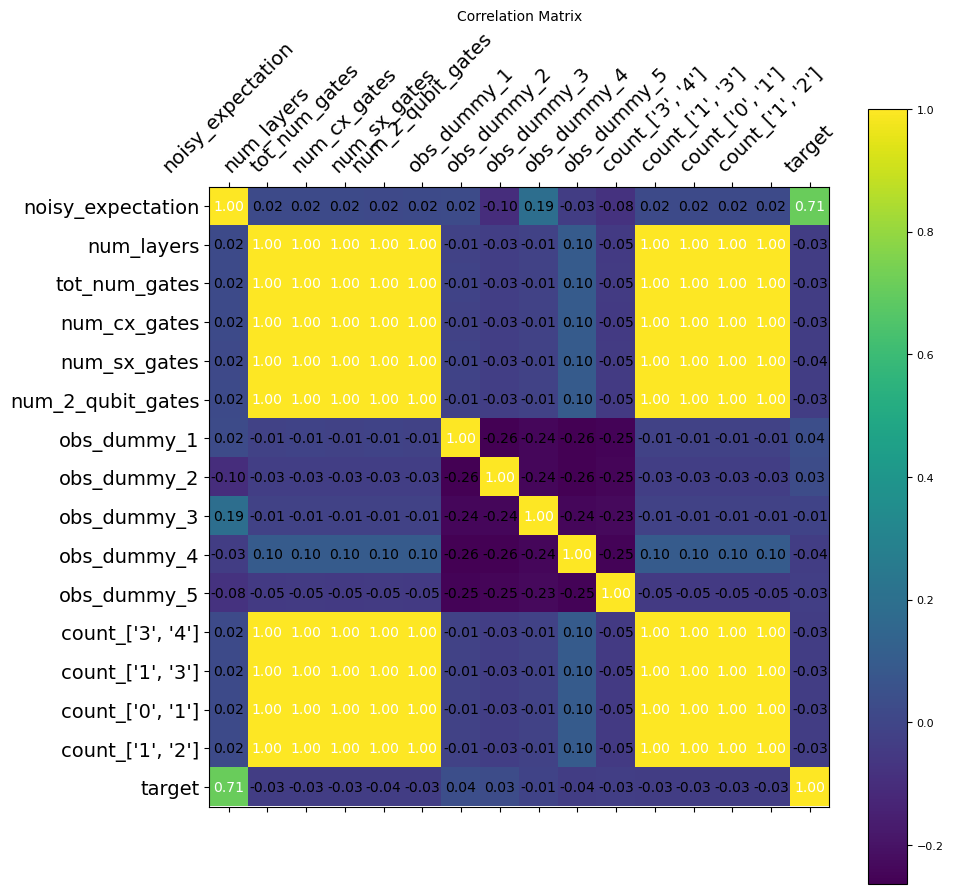

In [ ]:
from matplotlib import pyplot as plt

f = plt.figure(figsize=(10, 10))
plt.matshow(df_train.corr(), fignum=f.number)
for (i, j), val in np.ndenumerate(df_train.corr().values):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='white' if abs(val) > 0.5 else 'black')
plt.xticks(range(df_train.select_dtypes(['number']).shape[1]), df_train.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_train.select_dtypes(['number']).shape[1]), df_train.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.title('Correlation Matrix', fontsize=10)

In [ ]:
MSE_unmit = mean_squared_error(y_eval, df_eval['noisy_expectation'])
R2_unmit = r2_score(y_eval, df_eval['noisy_expectation'])
MSE_unmit

0.05572392094844572

Text(0.5, 1.0, 'MSE values of models')

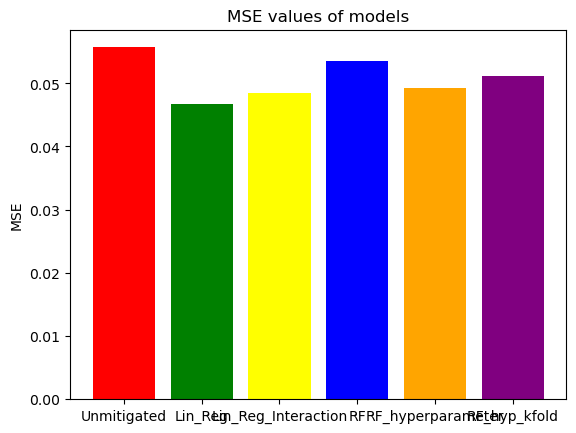

In [ ]:
fig, ax = plt.subplots()

models = ['Unmitigated', 'Lin_Reg', 'Lin_Reg_Interaction', 'RF', 'RF_hyperparameter', 'RF_hyp_kfold']
MSE_error =[MSE_unmit, MSE_lin_reg, MSE_lri, MSE_rf, MSE_rf_hyperparam, MSE_rf_hyp_kfold]
colors = ['red', 'green', 'yellow', 'blue', 'orange', 'purple']

ax.bar(models, MSE_error, color = colors)
ax.set_ylabel('MSE')
ax.set_title('MSE values of models')

Text(0.5, 1.0, 'R2 values of models')

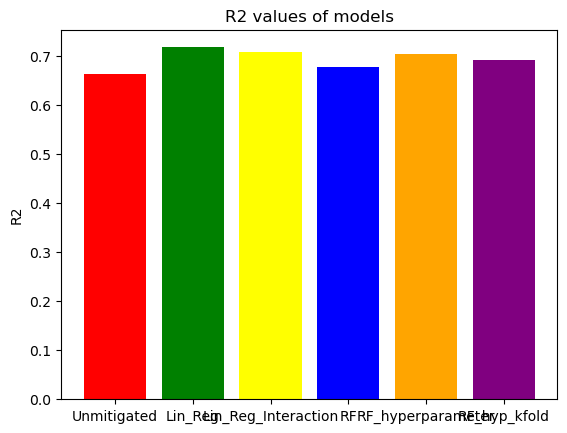

In [ ]:
fig, ax = plt.subplots()

models = ['Unmitigated', 'Lin_Reg', 'Lin_Reg_Interaction', 'RF', 'RF_hyperparameter', 'RF_hyp_kfold']
R2_error =[R2_unmit, R2_lin_reg, R2_lri, R2_rf, R2_rf_hyperparam, R2_rf_hyp_kfold]

ax.bar(models, R2_error, color = colors)
ax.set_ylabel('R2')
ax.set_title('R2 values of models')

### check ols.pk file from IBM GitHub

In [ ]:
import pandas as pd

obj = pd.read_pickle(r'ols.pk')
print(obj.coef_)
print(obj.intercept_)
print(len(obj.coef_[0]))

[[ 1.1216646e+00 -2.4618697e-03 -2.8624609e-03 -2.7975920e-03]
 [-5.2955630e-03  1.1233268e+00 -2.4385452e-03 -1.4796257e-03]
 [-3.6180143e-03 -2.8818250e-03  1.1190038e+00  1.6742945e-04]
 [-2.3743168e-03 -3.0452609e-03  1.2800395e-03  1.1206498e+00]]
[0.05158463 0.05154502 0.04959808 0.05179308]
4


In [3]:
obj_f = pd.read_pickle(r'ols_full.pk')
# print(obj_f.coef_)
# print(obj_f.intercept_)
print(len(obj_f.coef_[0]))

58


In [ ]:
print(best_model_lin.coef_)
print(best_model_lin.intercept_)

[ 1.13470756e+00 -6.79517597e-05  3.89689297e-03 -5.43614077e-04
 -1.47144853e-02 -5.43614077e-04  1.90283659e-02  6.86337308e-02
 -1.19509531e-01  3.53842047e-03  2.83090136e-02 -1.35903519e-04
 -1.35903519e-04 -1.35903519e-04 -1.35903519e-04]
-0.03827443173009812
